# Finding Topics in News Article

Finding Topics in News Articles is a model that will be used to identify topics of interest to readers.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


## Import Libraries

Libraries that have been used in this analysis include:

pandas, numpy, and nltk for preprocessing data

matplotlib and seaborn for creating visualizations

sklearn and scipy to develop models

In [47]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import Counter
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dataset

The dataset was assembled in 2020.The dataset contains information about newsdesk, section, subsection, material, headline, abstract, keywords, word_count, pub_date, n_comments, and uniqueID. Data set consists of 11 columns and 16787 rows of data

In [4]:
df = pd.read_csv("nyt-articles-2020.csv")

In [5]:
df.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [6]:
df.shape

(16787, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   newsdesk    16787 non-null  object
 1   section     16787 non-null  object
 2   subsection  5693 non-null   object
 3   material    16787 non-null  object
 4   headline    16787 non-null  object
 5   abstract    16784 non-null  object
 6   keywords    16786 non-null  object
 7   word_count  16787 non-null  int64 
 8   pub_date    16787 non-null  object
 9   n_comments  16787 non-null  int64 
 10  uniqueID    16787 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


## Exploratory Data Analysis


EDA is used to understand the data better. How the distribution of data variables.

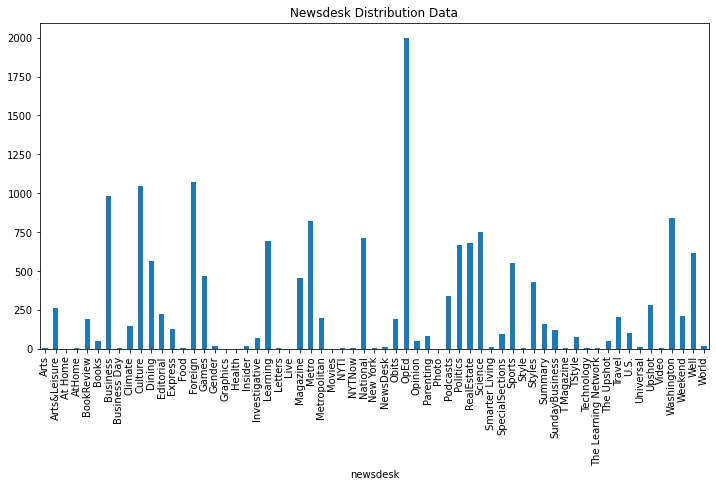

In [11]:
df.groupby('newsdesk').size().plot(kind='bar', figsize=(12,6))
plt.title('Newsdesk Distribution Data')
plt.ylabel('')
plt.show()

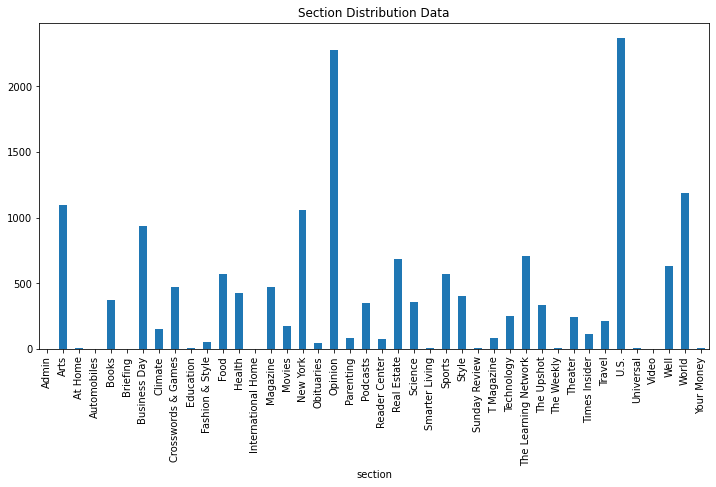

In [12]:
df.groupby('section').size().plot(kind='bar', figsize=(12,6))
plt.title('Section Distribution Data')
plt.ylabel('')
plt.show()

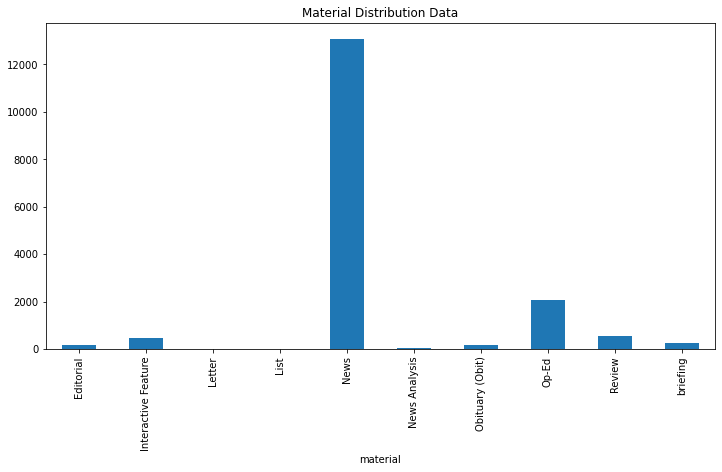

In [13]:
df.groupby('material').size().plot(kind='bar', figsize=(12,6))
plt.title('Material Distribution Data')
plt.ylabel('')
plt.show()

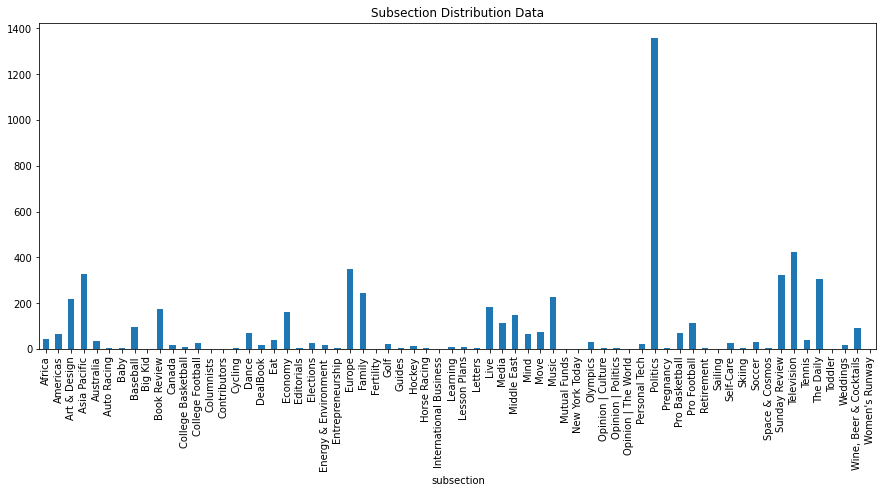

In [46]:
df.groupby('subsection').size().plot(kind='bar', figsize=(15,6))
plt.title('Subsection Distribution Data')
plt.ylabel('')
plt.show()

## Data Preparation


Data preparation is used to check, and to process the data become all variables on the data is ready to be used to make models.

In [15]:
df.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [16]:
print(df['abstract'].iloc[10])
print(df['headline'].iloc[10])
print(df['keywords'].iloc[10])

Intermittent fasting, drinking less alcohol and eating more oysters are some of the steps you can try.
Eat Better, Feel Better? Food Advice From the Year in Well
['Weight', 'Fasting', 'Diet and Nutrition']


In [17]:
#data cleaning

def text_cleaner(text):
    mention_pat= r'@[A-Za-z0-9_]+'
    mention_2_pat=r'@[A-Za-z0-9_]+:\s'
    
    #Remove mention
    text = re.sub(mention_2_pat,'', text)
    text = re.sub(mention_pat,'', text)

    #Remove newline characters 
    text = text.replace('\n', ' ') 

    #Remove multiple spaces
    text = re.sub("\s\s+" , " ", text)

    #Remove hashtag
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    text = " ".join(word.strip() for word in re.split('#|_', text)) 

    #Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    #Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    #Lowercase
    text = text.lower()

    #Remove any spaces at the start or end of the text
    text = text.strip()

    #Remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    text_split = text.split() 
    text_split = [x for x in text_split if x not in stopwords_list] 
    text = ' '.join(text_split)
    return text.strip()

    return text

In [18]:
#Apply text_cleaner

df['newsdesk'] = df['newsdesk'].apply(text_cleaner)
df['section'] = df['section'].apply(text_cleaner)
df['material'] = df['material'].apply(text_cleaner)
df['headline'] = df['headline'].apply(text_cleaner)

In [19]:
df.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,editorial,opinion,NaN,editorial,protect veterans fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,games,crosswords games,NaN,news,green slimy,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,science,science,NaN,news,meteor showers 2020 light night skies,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,science,science,NaN,interactive feature,sync calendar solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,science,science,NaN,news,rocket launches trips mars 2020 space astronom...,A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


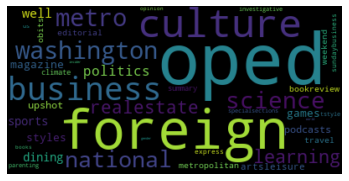

In [20]:
data_newsdesk = df['newsdesk'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data_newsdesk)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

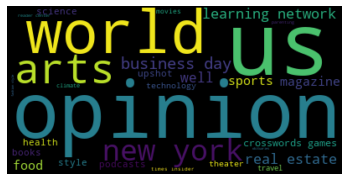

In [21]:
data_section = df['section'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data_section)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

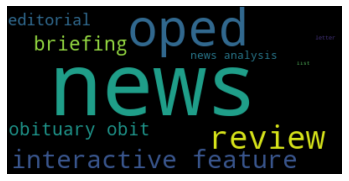

In [22]:
data_material = df['material'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data_material)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

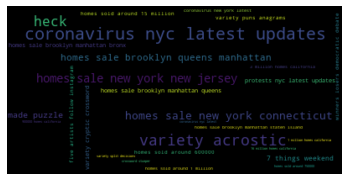

In [23]:
data_headline = df['headline'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data_headline)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Modelling

...

In [30]:
df = df[["newsdesk", "section", "subsection", "material", "word_count", "n_comments"]]
df.head()

,newsdesk,section,subsection,material,word_count,n_comments
0,editorial,opinion,NaN,editorial,680,186
1,games,crosswords games,NaN,news,931,257
2,science,science,NaN,news,1057,6
3,science,science,NaN,interactive feature,0,2
4,science,science,NaN,news,1156,25


In [31]:
category = ['newsdesk', 'section', 'subsection', 'material']

In [32]:
encoder = OneHotEncoder(handle_unknown="ignore", dtype=int)

In [33]:
categorical = encoder.fit_transform(df[category]).toarray()
categorical = pd.DataFrame(categorical, columns=encoder.get_feature_names_out())
categorical = pd.concat([categorical, df[["word_count", "n_comments"]]], axis=1)
categorical.head()

,newsdesk_arts,newsdesk_artsleisure,newsdesk_athome,newsdesk_bookreview,newsdesk_books,newsdesk_business,newsdesk_business day,newsdesk_climate,newsdesk_culture,newsdesk_dining,newsdesk_editorial,newsdesk_express,newsdesk_food,newsdesk_foreign,newsdesk_games,newsdesk_gender,newsdesk_graphics,newsdesk_health,newsdesk_home,newsdesk_insider,newsdesk_investigative,newsdesk_learning,newsdesk_learning network,newsdesk_letters,newsdesk_live,newsdesk_magazine,newsdesk_metro,newsdesk_metropolitan,newsdesk_movies,newsdesk_national,newsdesk_new york,newsdesk_newsdesk,newsdesk_nyti,newsdesk_nytnow,newsdesk_obits,newsdesk_oped,newsdesk_opinion,newsdesk_parenting,newsdesk_photo,newsdesk_podcasts,...,subsection_Move,subsection_Music,subsection_Mutual Funds,subsection_New York Today,subsection_Olympics,subsection_Opinion | Culture,subsection_Opinion | Politics,subsection_Opinion | The World,subsection_Personal Tech,subsection_Politics,subsection_Pregnancy,subsection_Pro Basketball,subsection_Pro Football,subsection_Retirement,subsection_Sailing,subsection_Self-Care,subsection_Skiing,subsection_Soccer,subsection_Space & Cosmos,subsection_Sunday Review,subsection_Television,subsection_Tennis,subsection_The Daily,subsection_Toddler,subsection_Weddings,"subsection_Wine, Beer & Cocktails",subsection_Women's Runway,subsection_nan,material_briefing,material_editorial,material_interactive feature,material_letter,material_list,material_news,material_news analysis,material_obituary obit,material_oped,material_review,word_count,n_comments
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,680,186
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,931,257
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1057,6
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1156,25


In [38]:
scaler = StandardScaler(with_mean=False)
scaled_categorical = pd.DataFrame(scaler.fit_transform(categorical))
scaled_categorical.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.658247,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.0,10.324155,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.719646,0.362296
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6.087048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.0,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,0.985280,0.500592
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.0,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,1.118626,0.011687
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.0,0.000000,6.184605,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.003896
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.112314,0.0,0.000000,0.000000,0.0,0.0,2.412884,0.0,0.0,0.0,0.0,1.223398,0.048696


In [39]:
def run_pca(data, n_components=None):
    pca = PCA(n_components)
    pc_df = pca.fit_transform(df)
    return pca, pc_df

In [48]:
 def run_pca(data, n_components=None):
    pca = PCA(n_components, random_state=11)
    pc_df = pca.fit_transform(data)
    return pca, pc_df


def scree_plot(pca, annotate=True):
    n_components = len(pca.explained_variance_ratio_)
    var_ratio = pca.explained_variance_ratio_.round(2)
    var_ratio_cumsum = var_ratio.cumsum()

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(range(n_components), var_ratio)
    ax.plot(range(n_components), var_ratio_cumsum, marker=".")
    if annotate:
        for component in range(n_components):
            ax.annotate(f"{var_ratio[component]*100}%", (component, var_ratio[component]), va="bottom", ha="center", fontsize=10)
        ax.yaxis.set_tick_params(width=0)
        ax.xaxis.set_tick_params(width=2, length=5)
    ax.set_xlabel("Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_title("Explained Variance per Components")
    plt.show()

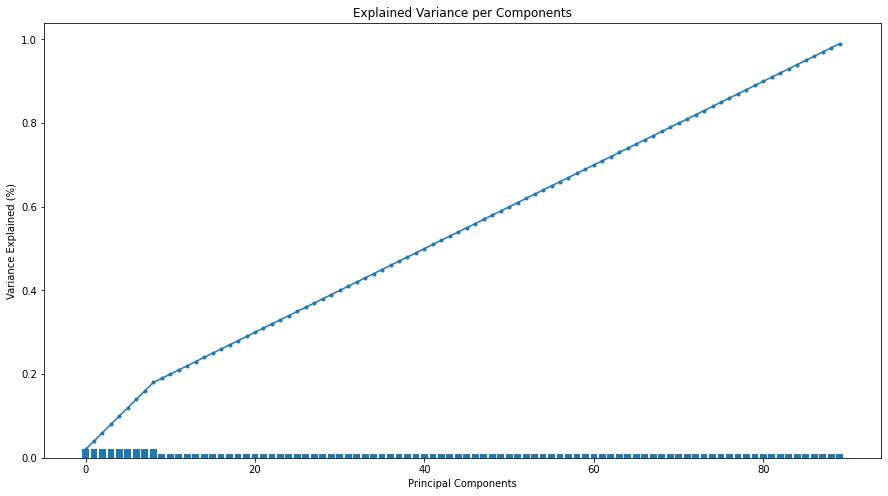

In [49]:
pca, pc_df = run_pca(scaled_categorical, n_components=90)
scree_plot(pca, annotate=False)

In [50]:
pca.explained_variance_ratio_.cumsum()

array([0.0245559 , 0.04278218, 0.06071639, 0.07779209, 0.09437832,
       0.11086571, 0.12729782, 0.14351957, 0.15867335, 0.17230943,
       0.1855305 , 0.19838314, 0.21111222, 0.22356917, 0.23567536,
       0.24774415, 0.259547  , 0.27108659, 0.28256008, 0.29396373,
       0.30525268, 0.31635399, 0.32742794, 0.33848013, 0.34942856,
       0.35966592, 0.36949752, 0.37927592, 0.38840614, 0.39749797,
       0.40651052, 0.41492579, 0.42290559, 0.43062761, 0.43803711,
       0.44527355, 0.45189341, 0.45848314, 0.46504897, 0.47138705,
       0.47762365, 0.48382019, 0.48991479, 0.49593193, 0.50190768,
       0.50783478, 0.51373598, 0.51956216, 0.52530681, 0.53103896,
       0.53670053, 0.54231949, 0.54792382, 0.55350384, 0.55907759,
       0.5646396 , 0.57019845, 0.57574753, 0.58129202, 0.58683417,
       0.59237502, 0.59791192, 0.60344725, 0.60898183, 0.61451443,
       0.62004601, 0.62557671, 0.63110584, 0.63663369, 0.64216055,
       0.64768702, 0.65321271, 0.65873776, 0.66426063, 0.66978

In [51]:
sse = {}
silhouette = {}
clusters = range(160, 181, 1)

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(pc_df)
    sse[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(pc_df, kmeans.predict(pc_df))


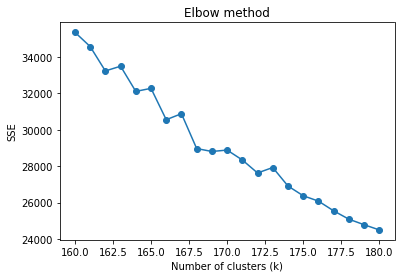

In [52]:
plt.plot(list(sse.keys()), list(sse.values()), "-o")
plt.title("Elbow method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.grid(False)

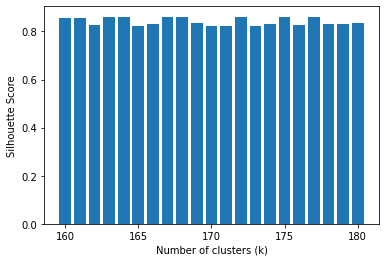

In [53]:
plt.bar(silhouette.keys(), silhouette.values())
# plt.title("Silhouette Scores for each number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(False)
plt.show()

In [54]:
print(silhouette)

{160: 0.8558813978682308, 161: 0.8546358072128186, 162: 0.8287689066140045, 163: 0.858419239174523, 164: 0.8601449780948421, 165: 0.8225085365732345, 166: 0.8296700903414537, 167: 0.8597681497115228, 168: 0.8602804297686458, 169: 0.8334448960646146, 170: 0.8240459175018089, 171: 0.8228353678040752, 172: 0.8593002905354414, 173: 0.82394157006961, 174: 0.8310935815408819, 175: 0.8614842019402903, 176: 0.8282588964673143, 177: 0.8605713783802543, 178: 0.830281852392012, 179: 0.8304639272792044, 180: 0.8347363011323491}


## Conclussion

Based on the silhouette score, k_175 gives the highest score, which is 0.861

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28bf8904-fc46-4c0e-afa1-b244d28dcc2e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>